# Credit-Card Default Risk
by Perry Shyr
## _3-of-7. Feature Engineering_
![](../image_files/cards.png)

## Problem Statement

Given a dataset with demographic and borrowing history data for accounts classified as defaulting or not defaulting in October-2005, can I build a supervised model that performs better than identifying only members of the negative non-default class (baseline model) while minimizing the misclassification of either class?  In the context of credit-card lending, if I can predict accounts as belonging to the defaulting class, I want to minimize the number of predicted defaulters who did not actually default that October (lost revenues) while minimizing the number of predicted non-defaulters who did end up defaulting (lost profits).

## Preamble for Feature-engineering Notebook

In this notebook, I create two sets of new monthly features.  The first is for a measure of leverage by calculating the ratio of bill-amount to credit-limit.  The motivation is to compare how levered the two classes are towards the end of the six months of borrowing-activity data collected.  The second set of interaction terms is designed to provide a sense of how much borrowing is carried as a multiple of the average payment amount each month.  My idea is that the default class might not be keeping up with payments towards new spending.  The hope is that these new features are easier for the network to learn, but not contribute much to overfitting (increased variance).  Finally, I also use on-hot encoding for the demographic which are numerically discrete into separate categorical features.


## A. Code Libraries Used

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## B. Load Data from Notebook-1

There were no results from our data-exploration notebook that were saved nor carried over for this current notebook.

In [3]:
accts = pd.read_csv('../asset_files/credit_data_processed.csv', index_col='ID')

In [15]:
print(accts.shape)     # Review the attributes of the data.
accts.head()

(29965, 24)


,credit_limit,gender,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,Oct_Default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## C. Create new features that might serve as better predictors of the positive class.

The characteristics that support the choice of a new feature to model with include a feature that has higher values for the positive class relative to the negative class.  If this feature is also time-dependent and increasing over time, that would be beneficial for modeling.

Two features seem to show these properties.  These are 'leverage' as defined by how much credit is extended to an account in terms of the set limits to borrowing, and 'balance carried' as defined by the multiple of billed amount to amount paid towards that balance in the prior period.

In [4]:
accts['leverage_1'] = accts['BILL_AMT1']/accts['credit_limit']   # First new feature, Leverage.
accts['leverage_2'] = accts['BILL_AMT2']/accts['credit_limit']
accts['leverage_3'] = accts['BILL_AMT3']/accts['credit_limit']
accts['leverage_4'] = accts['BILL_AMT4']/accts['credit_limit']
accts['leverage_5'] = accts['BILL_AMT5']/accts['credit_limit']
accts['leverage_6'] = accts['BILL_AMT6']/accts['credit_limit']

In [39]:
accts['bill_to_pay1'] = accts['BILL_AMT1']/(accts['PAY_AMT1']+1)   # Second new features, Balance-carried.
accts['bill_to_pay2'] = accts['BILL_AMT2']/(accts['PAY_AMT2']+1)
accts['bill_to_pay3'] = accts['BILL_AMT3']/(accts['PAY_AMT3']+1)
accts['bill_to_pay4'] = accts['BILL_AMT4']/(accts['PAY_AMT4']+1)
accts['bill_to_pay5'] = accts['BILL_AMT5']/(accts['PAY_AMT5']+1)
accts['bill_to_pay6'] = accts['BILL_AMT6']/(accts['PAY_AMT6']+1)

In [20]:
print(accts.shape)
accts.describe().T

(29965, 36)


,count,mean,std,min,25%,50%,75%,max
credit_limit,29965.0,167442.005006,129760.135222,10000.000000,50000.000000,140000.000000,240000.000000,1.000000e+06
gender,29965.0,1.603738,0.489128,1.000000,1.000000,2.000000,2.000000,2.000000e+00
EDUCATION,29965.0,1.842750,0.744513,1.000000,1.000000,2.000000,2.000000,4.000000e+00
MARRIAGE,29965.0,1.551877,0.521997,0.000000,1.000000,2.000000,2.000000,3.000000e+00
AGE,29965.0,35.487969,9.219459,21.000000,28.000000,34.000000,41.000000,7.900000e+01
PAY_0,29965.0,-0.016753,1.123492,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_2,29965.0,-0.131854,1.196322,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_3,29965.0,-0.164392,1.195878,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_4,29965.0,-0.218922,1.168175,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_5,29965.0,-0.264509,1.132220,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00


We see the new features added bringing the total of predictor candidates to 35.  

Let's look at some quick plots of these new features.  First, I'll mask the rows into a DataFrame for the Non-Default class, and a DataFrame for the Default class.

In [5]:
accts_0=accts[accts['Oct_Default']==0]
accts_1=accts[accts['Oct_Default']==1]

In [6]:
def plot_months(cols,min,max,labls,my_title):
    plt.figure(figsize=(12,8))
    plt.plot(accts[cols].mean(),lw=3,label='Combined')
    plt.plot(accts_0[cols].mean(),lw=3,label='Non-default')
    plt.plot(accts_1[cols].mean(),lw=3,label='Default')
    plt.title(my_title,fontsize='xx-large')
    loc,labels = plt.xticks()
    labels=labls
    plt.ylim(min,max)
    plt.xticks(loc,labels,fontsize='xx-large')
    plt.yticks(fontsize='xx-large')
    plt.legend(shadow=True, fontsize='xx-large')

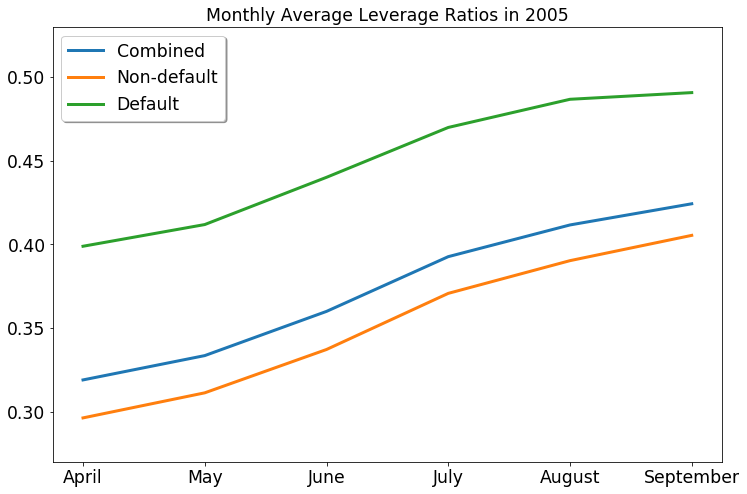

In [40]:
leverage_columns=['leverage_6', 'leverage_5', 'leverage_4',
                 'leverage_3', 'leverage_2', 'leverage_1']
min_y = 0.27
max_y = 0.53
title = 'Monthly Average Leverage Ratios in 2005'
labels=['April','May','June','July','August','September']
plot_months(leverage_columns,min_y,max_y,labels,title)

We can see that the Default group is levered more or using more of their credit availability than the Non-default group.

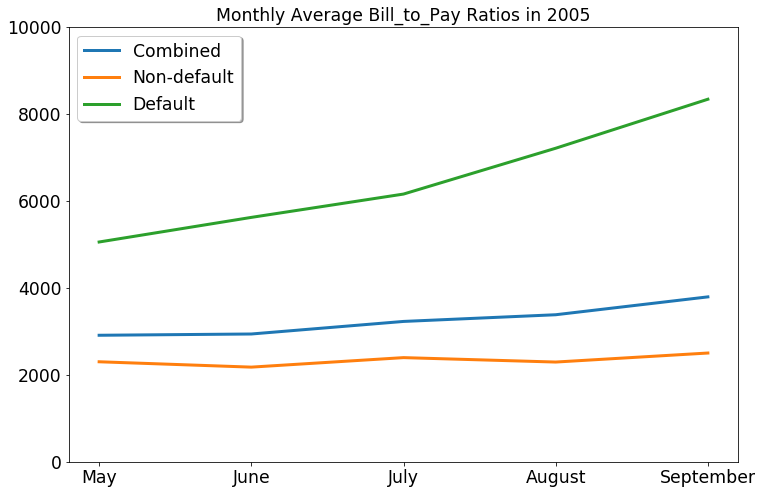

In [44]:
bill_pay_columns=['bill_to_pay5', 'bill_to_pay4', 'bill_to_pay3',
                 'bill_to_pay2', 'bill_to_pay1']
min_y = 0
max_y = 10000
title = 'Monthly Average Bill_to_Pay Ratios in 2005'
labels=['May','June','July','August','September']
plot_months(bill_pay_columns,min_y,max_y,labels,title)

We can see above that the Default group is struggling to keep up with their debt.  These are promising interaction terms because both trends are increasing over time and the behaviors of the two classes are noticeably different.

Let's now separate the ordinal demographic values into their own feature columns for gender, EDUCATION and MARRIAGE.

In [40]:
accts['gender_m'] = accts['gender'].map(lambda x: 1 if x in {1} else 0)
accts['gender_f'] = accts['gender'].map(lambda x: 1 if x in {2} else 0)

In [41]:
accts['edu_grad_schl'] = accts['EDUCATION'].map(lambda x: 1 if x in {1} else 0)
accts['edu_college'] = accts['EDUCATION'].map(lambda x: 1 if x in {2} else 0)
accts['edu_high_schl'] = accts['EDUCATION'].map(lambda x: 1 if x in {3} else 0)
accts['edu_other'] = accts['EDUCATION'].map(lambda x: 1 if x in {4} else 0)

In [42]:
accts['marital_mrrd'] = accts['MARRIAGE'].map(lambda x: 1 if x in {1} else 0)
accts['marital_sngl'] = accts['MARRIAGE'].map(lambda x: 1 if x in {2} else 0)
accts['marital_dvcd'] = accts['MARRIAGE'].map(lambda x: 1 if x in {3} else 0)
accts['marital_othr'] = accts['MARRIAGE'].map(lambda x: 1 if x in {4} else 0)

Let's drop the original 'gender,' 'EDUCATION' and 'MARRIAGE' columns now.

In [43]:
accts = accts.drop('gender', axis=1)
accts = accts.drop('EDUCATION', axis=1)
accts = accts.drop('MARRIAGE', axis=1)

Let's look at the dataset one more time to check what we have.

In [44]:
accts.describe().T

,count,mean,std,min,25%,50%,75%,max
credit_limit,29965.0,167442.005006,129760.135222,10000.000000,50000.000000,140000.000000,240000.000000,1.000000e+06
AGE,29965.0,35.487969,9.219459,21.000000,28.000000,34.000000,41.000000,7.900000e+01
PAY_0,29965.0,-0.016753,1.123492,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_2,29965.0,-0.131854,1.196322,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_3,29965.0,-0.164392,1.195878,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_4,29965.0,-0.218922,1.168175,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_5,29965.0,-0.264509,1.132220,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
PAY_6,29965.0,-0.289438,1.149090,-2.000000,-1.000000,0.000000,0.000000,8.000000e+00
BILL_AMT1,29965.0,51283.009778,73658.132403,-165580.000000,3595.000000,22438.000000,67260.000000,9.645110e+05
BILL_AMT2,29965.0,49236.366294,71195.567392,-69777.000000,3010.000000,21295.000000,64109.000000,9.839310e+05


There are a total of 42 features now with one dependent target variable (for default status in October-2005).  Now that the features are prepared the way we want them, we can save the dataset for use in modeling.  

## E. Save the values to a separate file.

In [45]:
accts.to_csv('../asset_files/credit_new_features.csv')

## Continue to Notebook-4, Model Building.

We have progressed through the data-science workflow in these first three notebooks.  In the code above, six additional features have been added as promising candidates for being strong predictors.  The invalid values have been resolved, so the data is ready for next steps.  We may or may not use all of the features which we have thus far once features selection is called for.

In the next notebook, we will proceed with pre-modeling, test and optimize various classification models, score/predict, save and finally evaluate our choices for productiion deployment.